In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any
from bbtoolkit.structures.synapses import TensorGroup, DirectedTensor, dict2directed_tensor
from bbtoolkit.math import pol2cart
from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.preprocessing.environment import Geometry
from bbtoolkit.preprocessing.neural_generators import MTLGenerator, TCGenerator


In [2]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

['../cfg/connectivity/main.ini']

In [3]:
def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out

In [4]:
configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = TensorGroup(*connections)

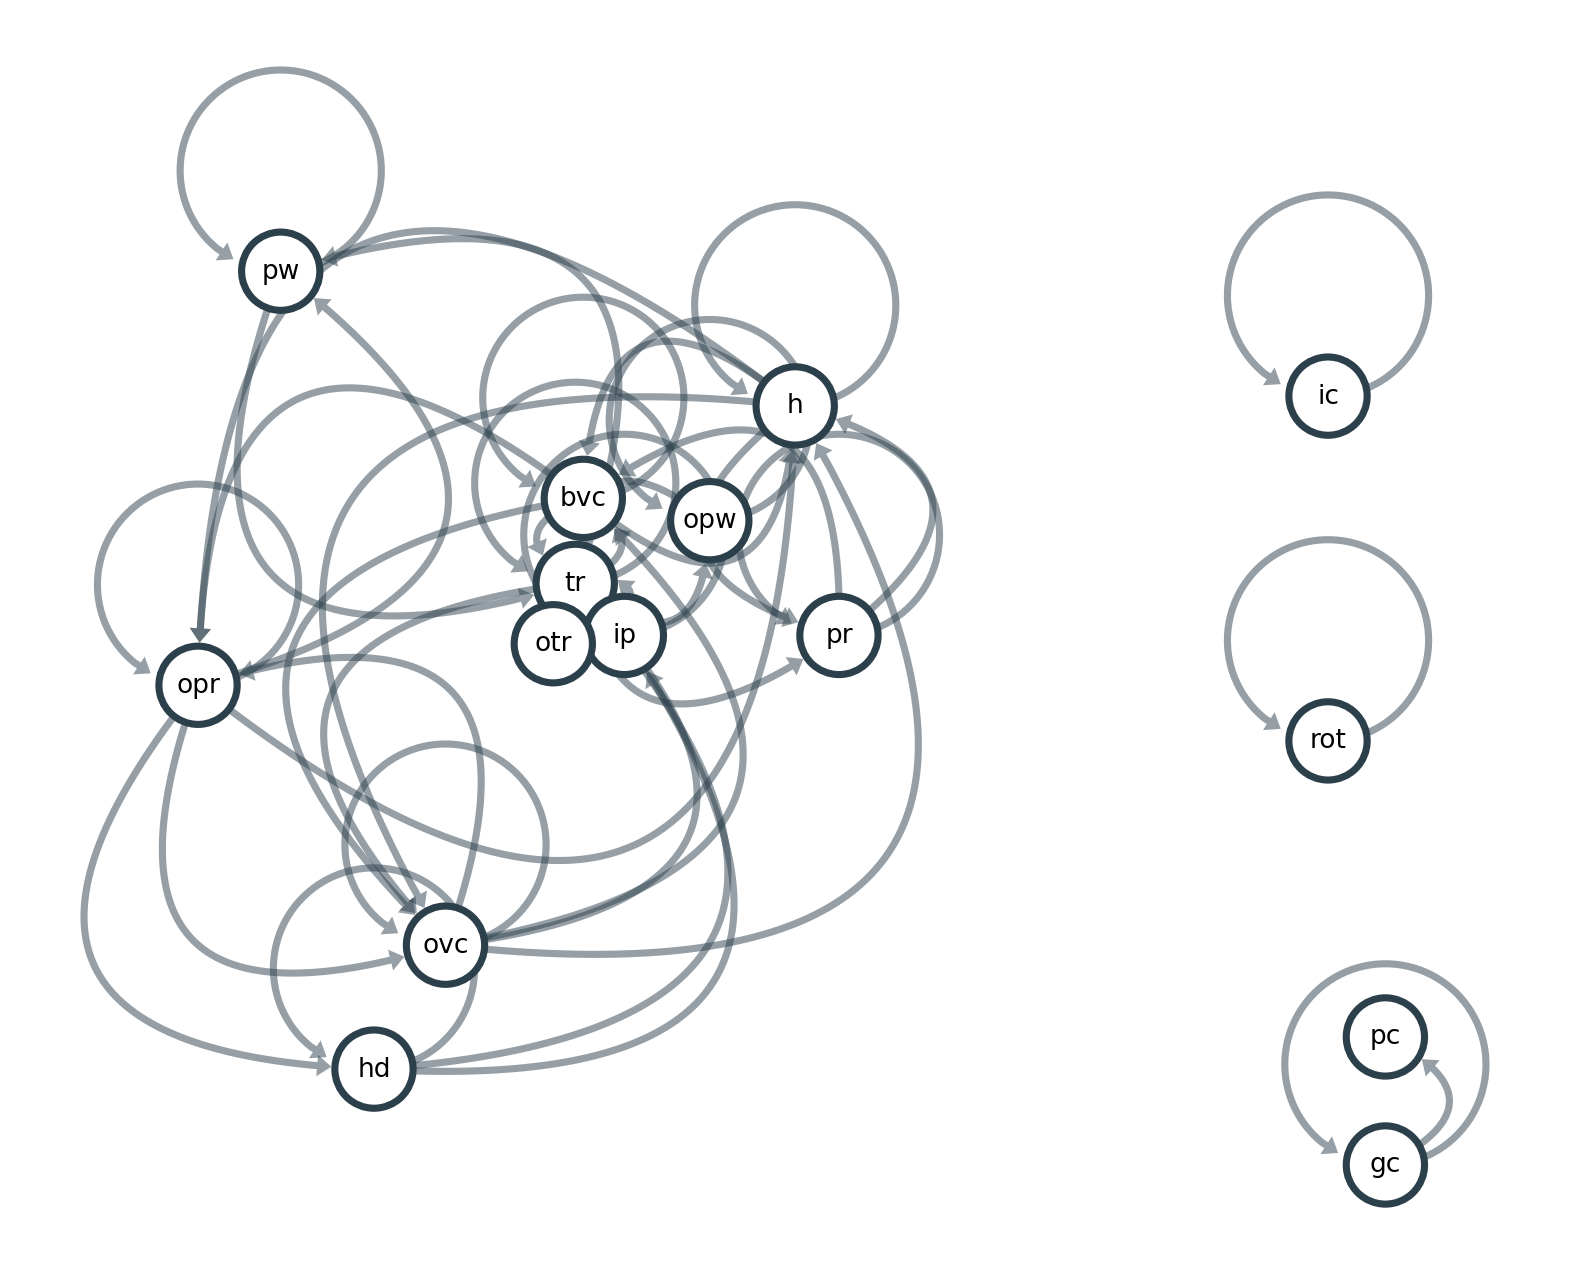

In [5]:
fig = connectivity.plot(edge_labels=False, node_layout='radial', edge_width=.5)

In [6]:
connectivity.connection_map

,pr,bvc,ovc,opr,tr,ip,rot,opw,ic,pw,gc,hd,h,pc,otr
pr,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
bvc,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
ovc,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0
opr,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0
tr,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0
ip,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
rot,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
opw,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
ic,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
pw,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [7]:
simconfig_path = '../cfg/simulation/one_one.ini'
simconfig = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
simconfig.read(simconfig_path)

['../cfg/simulation/one_one.ini']

In [8]:
dt = simconfig.eval('Simulation', 'dt')
step = simconfig.eval('Simulation', 'step')
lesion_noise_level =  simconfig.eval('Simulation', 'lesion_noise_level')
fr_noise_level = simconfig.eval('Simulation', 'fr_noise_level')

In [9]:
mtl_weights = TensorGroup.load('../data/weights/mtl_weights.pkl')
tc_weights = TensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = TensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = TensorGroup.load('../data/weights/pc_weights.pkl')

In [10]:
gc_map = GCMap.load('../data/weights/gc_map.pkl')

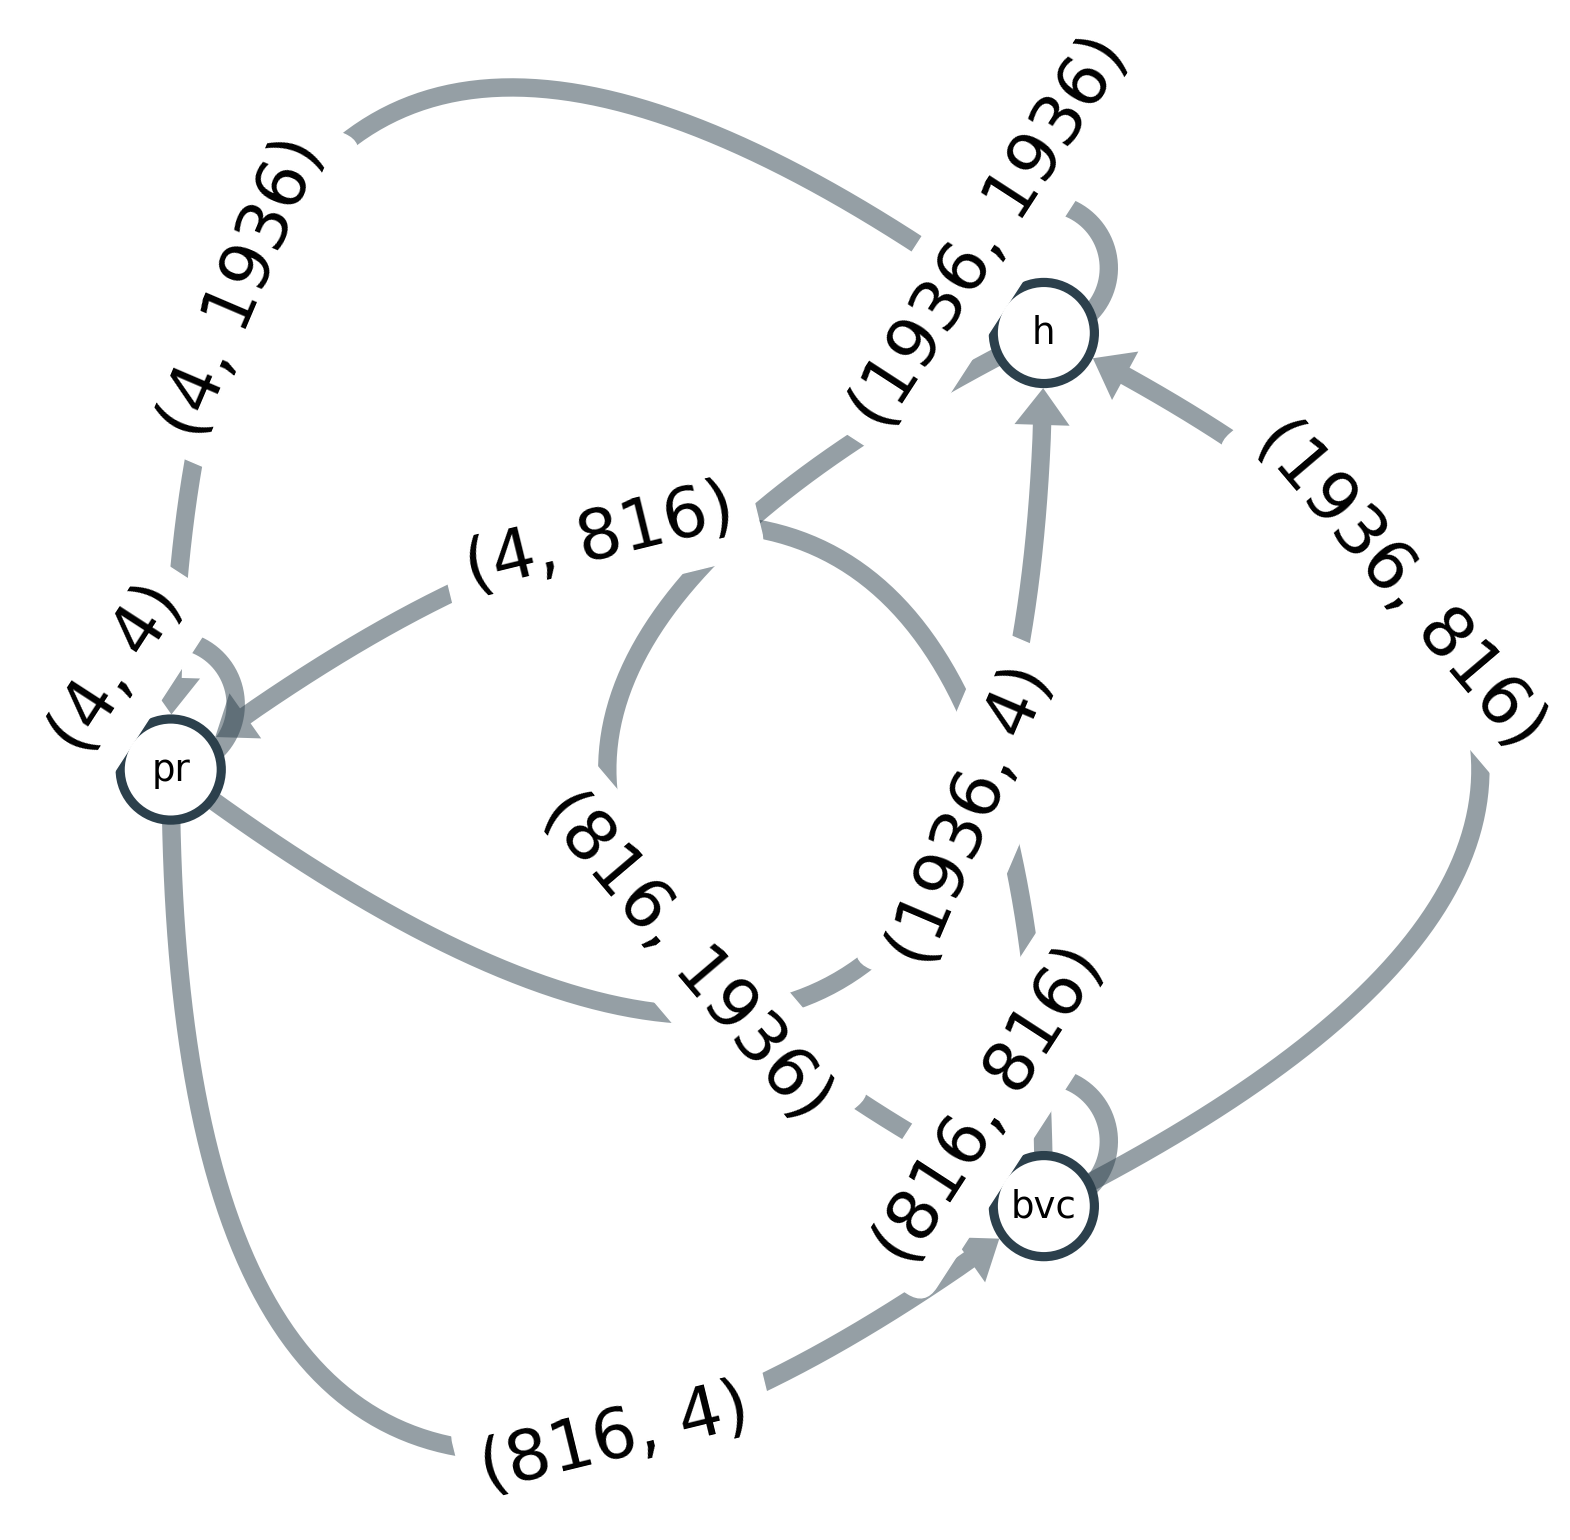

In [11]:
fig = mtl_weights.plot(scale=(.5, .5), edge_label_fontdict=dict(fontsize=50))

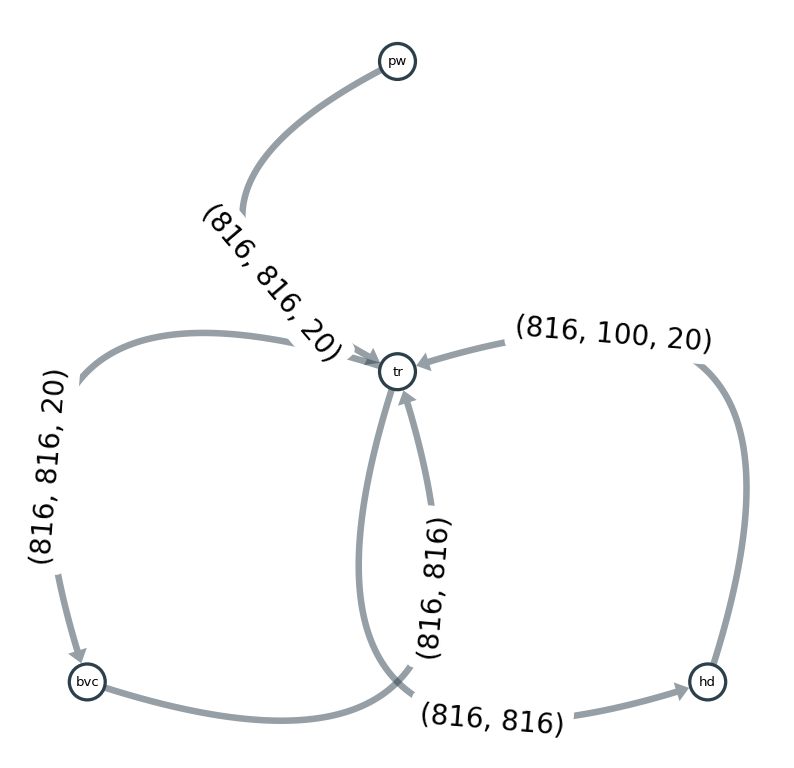

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
fig = tc_weights.plot(ax=ax, edge_label_fontdict=dict(fontsize=20))

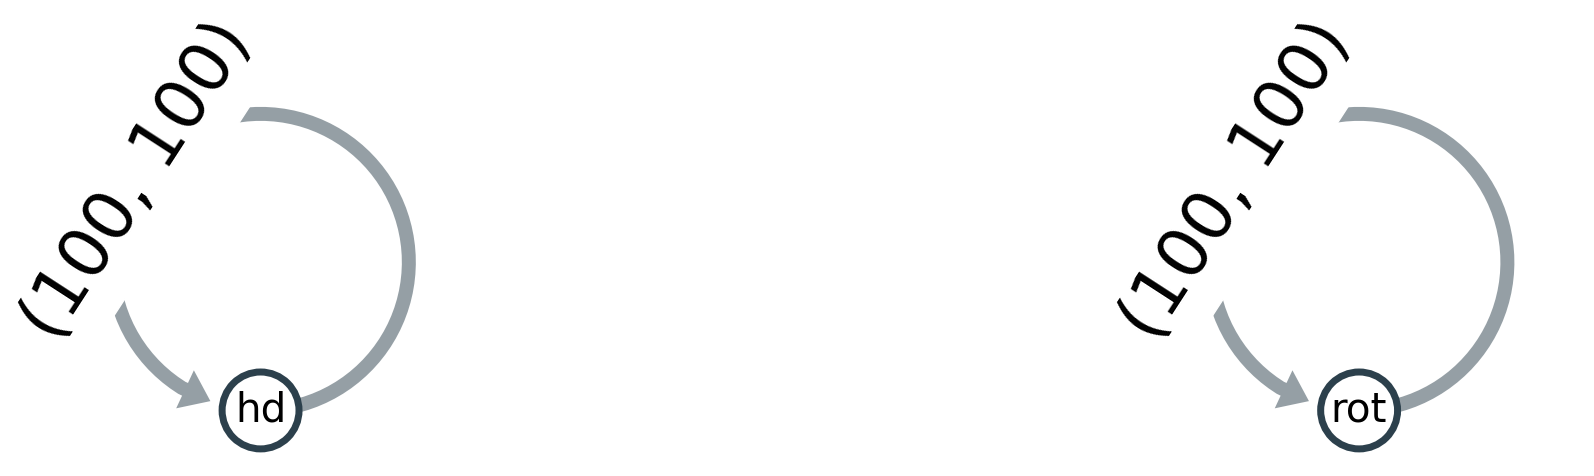

In [13]:
fig = hd_weights.plot(scale=(1.5, 1.5), edge_label_fontdict=dict(fontsize=50))

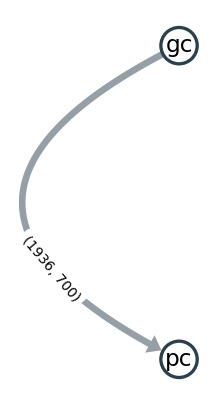

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = pc_weights.plot(ax=ax, scale=(.5, .5))

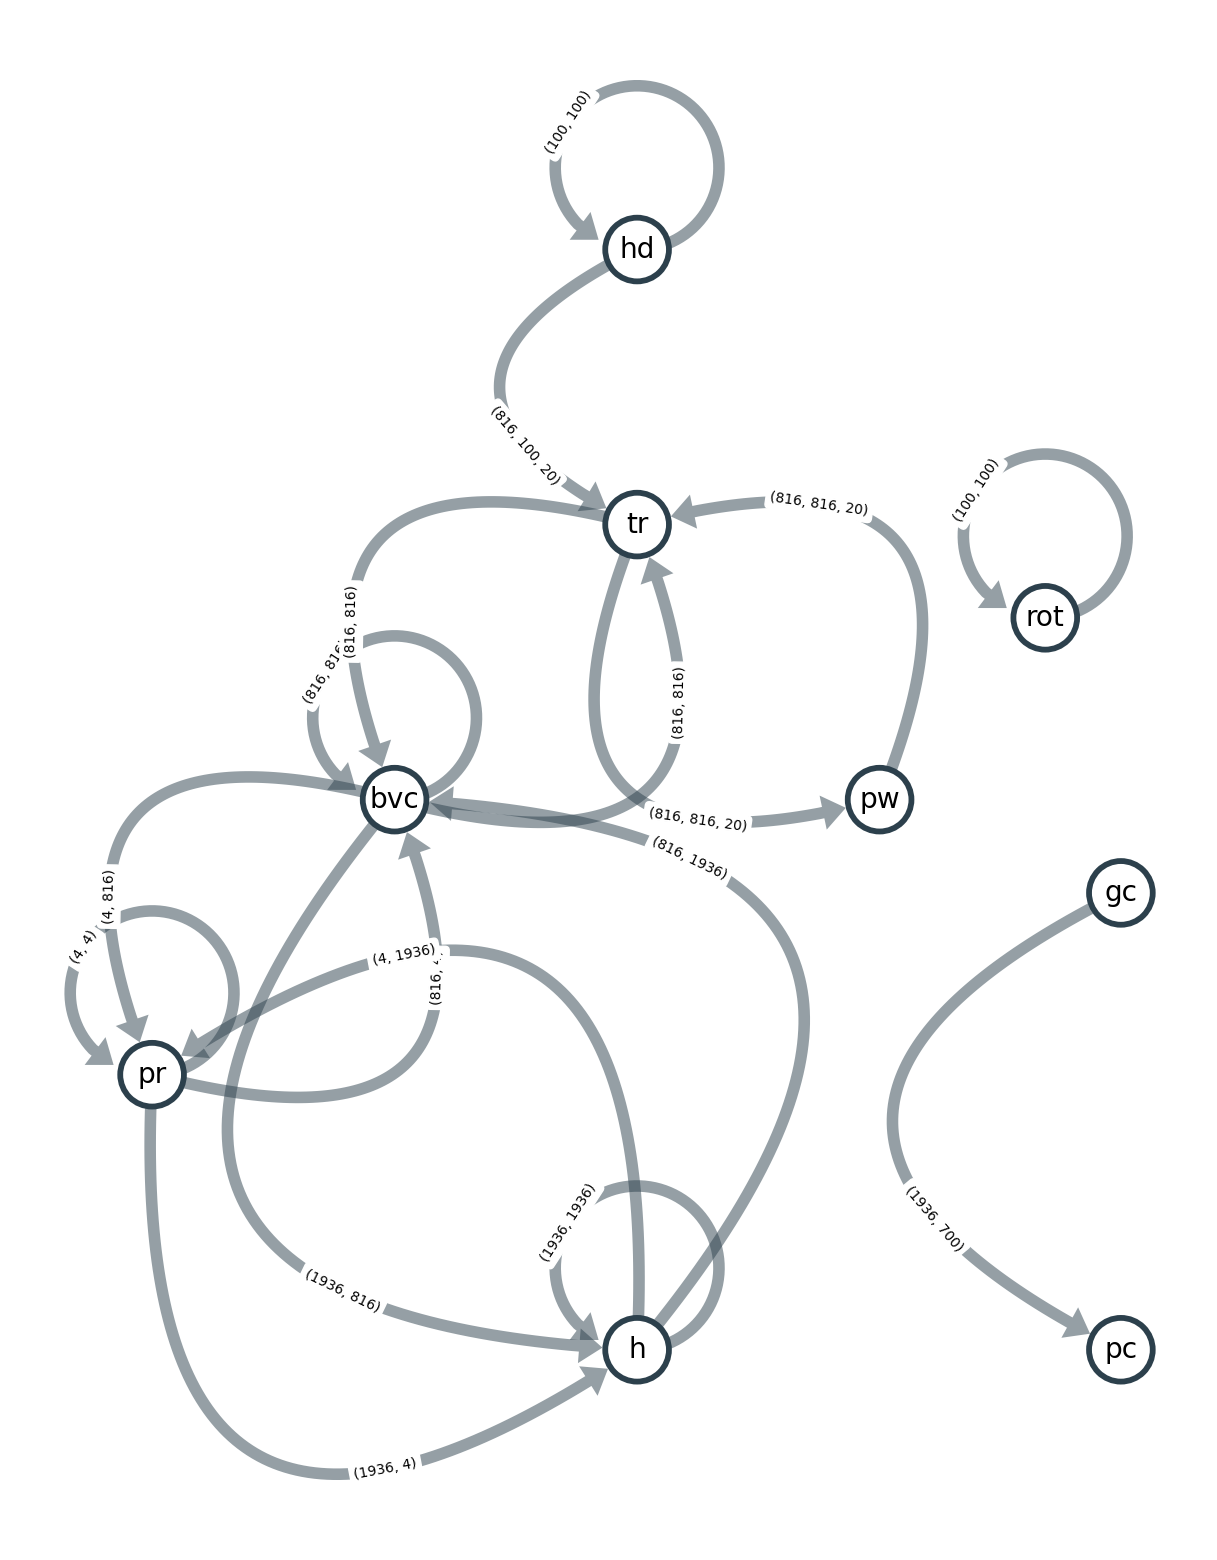

In [15]:
fig = (mtl_weights + tc_weights + hd_weights + pc_weights).plot()

In [16]:
weights = mtl_weights + tc_weights + hd_weights + pc_weights

In [17]:
n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.pc)
n_gc_neurons = len(weights.gc.to.pc.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [18]:
n_h_neurons, n_bvc_neurons, n_pr_neurons, n_hd_neurons, n_gc_neurons, n_opw_neurons, n_ovc_neurons

(1936, 816, 4, 100, 700, 816, 816)

In [19]:
tr_projection = TensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

In [20]:
# initialize activity to zeros

h_act = np.zeros((n_h_neurons, 1))
bvc_act = np.zeros((n_bvc_neurons, 1))
pr_act = np.zeros((n_pr_neurons, 1))
pw_act = bvc_act.copy()
hd_act = np.zeros((n_hd_neurons, 1))
ovc_act = bvc_act.copy()
opw_act = bvc_act.copy()
tr_act = np.zeros((n_tc_layers, n_bvc_neurons, 1))
gc = np.reshape(gc_map.fr, (*gc_map.fr.shape[:2], -1))

In [21]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')

training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

geometry = Geometry.load('../data/envs/squared_room.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    h_sig,
    sigma_angular,
    n_steps
)

mtl_gen = MTLGenerator(
    h_res, r_max, h_sig, polar_dist_res, polar_ang_res, geometry
)

In [22]:
h_coords, *_ = mtl_gen.get_coords()
pdist, pang = tc_gen.polar_distance, tc_gen.polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [23]:
trajectory_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
trajectory_cfg.read('../cfg/trajectory/papez_circuit_lesion.ini')

agent_cfg = trajectory_cfg['AgentPosition']
agent_x = agent_cfg.eval('x')
agent_y = agent_cfg.eval('y')
agent_hd = agent_cfg.eval('theta', locals={'pi': np.pi})
agent_v = agent_cfg.eval('v')

mode_cfg = trajectory_cfg['Mode']
perception = mode_cfg.eval('perception')
imagery = mode_cfg.eval('imagery')
movement = mode_cfg.eval('movement')
imaginary_movement = mode_cfg.eval('imaginary_movement')
stand_time = mode_cfg.eval('stand_t')

targets_cfg = trajectory_cfg['Targets']
locate_next_target = targets_cfg.eval('locate_next_target')
move_to_next_target = targets_cfg.eval('move_to_next_target')
rotation_resolved = targets_cfg.eval('rotation_resolved')
targets = np.array(targets_cfg.eval('targets'))

itargets_cfg = trajectory_cfg['ImaginaryTargets']
ilocate_next_target = itargets_cfg.eval('locate_next_target')
imove_to_next_target = itargets_cfg.eval('move_to_next_target')
irotation_resolved = itargets_cfg.eval('rotation_resolved')
itargets = np.array(itargets_cfg.eval('targets'))
idwell_time = itargets_cfg.eval('dwell')

objects_cfg = trajectory_cfg['Objects']
object_coords = np.array(objects_cfg.eval('coords'))
encoding_threshold = objects_cfg.eval('encoding_threshold')


connectivity_modified = connectivity.operation_with(
    TensorGroup(
        *dict2directed_tensor(
            connectivity_config2dict(
                trajectory_cfg, ignore=('AgentPosition', 'Mode', 'Targets', 'ImaginaryTargets', 'Objects')
            )
        )
    ),
    lambda dict1, dict2:
        {
            key: dict1.get(key, 1) * dict2.get(key, 1)
            for key in set(dict1) | set(dict2)
        }
)

In [24]:
# Input for BB_subr_PdrivePW_withObj

geometry.training_space.starting_points # r0
geometry.training_space.directions # dir
len(geometry.training_space.identities) # line
geometry.boundary.coords.x, geometry.boundary.coords.y # BndryPtX, BndryPtY
agent_x, agent_y, agent_hd # Xag, Yag, HDag

(5, 10, 3.141592653589793)

In [25]:
from bbtoolkit.preprocessing.environment import Coordinates2D, Point2D
from collections.abc import Sized


def get_spatial_cues(
    starting_points: np.ndarray,
    directions: np.ndarray,
    n_lines: int,
    boundary_points: Coordinates2D,
    agent_coords: Point2D,
    agent_hd: float,
    step: int = 0,
    modstep: int = 0,
    obj: int = None
):
    occ_one = np.ones((n_lines, 1))
    n_boundary_points = len(boundary_points.x)

    bp_ones = np.ones((n_boundary_points, 1))
    bp_zeros = np.zeros((n_boundary_points, 1))

    vis_xy = np.nan*np.ones((2, n_boundary_points, 1))
    
    # local_directions = 

In [26]:
from bbtoolkit.preprocessing.environment import process_visible_plane, Boundary
from bbtoolkit.math.geometry import compute_intersection

geometry = Geometry.load('../data/envs/squared_room.pkl')
# geometry = Geometry.load('../data/envs/squared_room_01.pkl')
# geometry = Geometry.load('../data/envs/squared_room_015.pkl')
# geometry = Geometry.load('../data/envs/squared_room_04.pkl')
# geometry = Geometry.load('../data/envs/squared_room_05.pkl')

starting_points = geometry.training_space.starting_points
directions = geometry.training_space.directions
n_lines = len(geometry.training_space.identities)
boundary_points = geometry.boundary.coords
agent_coords = Point2D(agent_x, agent_y)
agent_hd = agent_hd
step: int = 0,
modstep: int = 0,
obj: bool = False

In [27]:
occ_one = np.ones((n_lines, 1))
n_boundary_points = len(boundary_points.x)

bp_ones = np.ones((n_boundary_points))
bp_zeros = np.zeros((n_boundary_points))

vis_xy = np.nan*np.ones((2, n_boundary_points, 1))

local_starting_points = starting_points - occ_one*np.array([[agent_coords.x, agent_coords.y, 0]])
local_boundary_points = np.stack([boundary_points.x - agent_coords.x, boundary_points.y - agent_coords.y, np.zeros(n_boundary_points)]).T
occluded_points = np.zeros((n_boundary_points))


if not obj:
    for occluded_boundary in range(n_lines):
        alpha_pt, alpha_occ = compute_intersection(
            np.zeros((n_boundary_points, 3)),
            np.zeros_like(local_starting_points[occluded_boundary]*np.ones((n_boundary_points, 1))),
            local_boundary_points,
            directions[occluded_boundary]*np.ones((n_boundary_points, 1)),
        )
        occluded_points = np.logical_or(
            occluded_points,
            ((alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ <= 1) & (alpha_occ >= 0))
        )


unoccluded_points_indices = np.where(~occluded_points)[0]
n_visible_points = len(unoccluded_points_indices)


In [28]:
obj = False

training_space = geometry.training_space.copy()
training_space.coords = Coordinates2D(x=np.array([agent_x]), y=np.array([agent_y]))

if obj:
    training_space.starting_points = np.ones_like(training_space.starting_points) * np.array([[agent_x, agent_y, 0]])

vp = process_visible_plane(
    geometry.boundary,
    training_space
)
existing_points_indices = np.where(~np.isnan(vp.coords.x[0]))[0]
visible_boundary = Boundary(
    coords=Coordinates2D(
        x=vp.coords.x[0, existing_points_indices] - training_space.coords.x,
        y=vp.coords.y[0, existing_points_indices] - training_space.coords.y
    ),
    textures=vp.textures[0, existing_points_indices]
)

r = np.array([
    [np.cos(agent_hd), -np.sin(agent_hd)],
    [np.sin(agent_hd), np.cos(agent_hd)]
])

if obj:
    r = r.T


rotated_coords = r@np.stack([visible_boundary.coords.x, visible_boundary.coords.y])
visible_boundary_rotated = Boundary(
    coords=Coordinates2D(
        x=rotated_coords[0],
        y=rotated_coords[1]
    ),
    textures=visible_boundary.textures
)

mask_180_deg = rotated_coords[1] > 0
fov_x = visible_boundary.coords.x[mask_180_deg] # field of view
fov_y = visible_boundary.coords.y[mask_180_deg]
diffvec = np.diff(np.stack([fov_x, fov_y]), axis=1)

In [29]:
from typing import Callable

def find_index_ranges(arr: np.ndarray, condition: Callable[[np.ndarray], np.ndarray]) -> list[tuple[int, int]]:
    """
    Finds ranges of indices in an array satisfying a condition.

    Args:
        arr (np.ndarray): An array to search.
        condition (Callable[[np.ndarray], np.ndarray]): A function returning a boolean array.

    Returns:
        list[tuple[int, int]]: A list of tuples containing start and end indices of ranges satisfying the condition.
    """
    indices = np.where(condition(arr))[0]
    ranges = []
    start = indices[0]
    for i in range(1, len(indices)):
        if indices[i] != indices[i - 1] + 1:
            ranges.append((start, indices[i - 1]))
            start = indices[i]
    ranges.append((start, indices[-1]))
    return ranges

In [30]:
np.unique(np.abs(diffvec).sum(axis=0))

array([0. , 0.2, 0.3, 0.3, 0.3, 0.3, 8.9])

In [31]:
np.unique(np.abs(diffvec).sum(axis=0))

array([0. , 0.2, 0.3, 0.3, 0.3, 0.3, 8.9])

In [32]:
np.abs(diffvec).sum(axis=0)

array([8.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0. , 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

In [33]:
np.abs(diffvec).sum(axis=0)

array([8.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0. , 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

In [34]:
np.abs(diffvec).sum(axis=0)

array([8.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0. , 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

In [35]:
0.4 / 3

0.13333333333333333

In [36]:
np.unique(np.abs(diffvec).sum(axis=0))

array([0. , 0.2, 0.3, 0.3, 0.3, 0.3, 8.9])

In [37]:
np.abs(diffvec).sum(axis=0)

array([8.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0. , 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

In [38]:
np.abs(diffvec).sum(axis=0)

array([8.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0. , 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

In [39]:
np.abs(diffvec).sum(axis=0)

array([8.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0. , 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

In [40]:
diffsum = np.round(np.abs(diffvec).sum(axis=0)*10, 0)

ranges = find_index_ranges(diffsum, lambda x: x == int(training_space.resolution*10) - int(obj)) # wtf with this condition?!
ranges = [[start, min(stop + 1, len(diffsum) - 1)] for start, stop in ranges] # stop + 1 to include the point at the end of the range
indices = [[i for range_ in ranges for i in range_]]

landmarks = np.concatenate([fov_x[indices], fov_y[indices]], 0)

if landmarks.size == 0:
    landmarks_rotated = np.array([])
    egocue = np.array([])
else:
    landmarks_rotated = r@landmarks
    egocue = np.reshape(landmarks_rotated, (4, -1), order='F').T


In [41]:
egocue

array([[-16. ,   0.1, -16. ,   8.8],
       [-16. ,   9. ,   3.8,   9. ],
       [  4. ,   9. ,   4. ,   0.6]])

In [42]:
object_coords

array([[12, 12]])

In [43]:
object_coords = [[]]

In [44]:
object_coords = (-20 + 40*np.random.rand(100,2)).astype(int)

In [45]:
n_objects = len(object_coords)
object_points_x = np.zeros((n_objects, 5)) # 5 points per object (closed rectangular polygon)
object_points_y = object_points_x.copy()
object_center_x = np.zeros((n_objects, 1))
object_center_y = object_center_x.copy()

In [375]:
def create_pentagrams(centers, r=1, res=.3):
    n_objects = centers.shape[1]
    x_coords = np.zeros((n_objects, 5))
    y_coords = np.zeros((n_objects, 5))
    x_upscaled, y_upscaled = list(), list()

    for obj in range(n_objects):
        for j in range(5):
            angle = 2 * np.pi * j / 5
            x_coords[obj, j] = centers[obj, 0] + r * np.cos(angle)
            y_coords[obj, j] = centers[obj, 1] + r * np.sin(angle)

    return x_coords, y_coords

object_points_x, object_points_y = create_pentagrams(object_coords, 1)

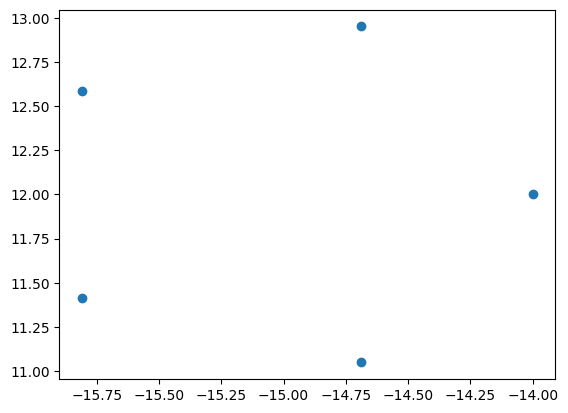

In [376]:
plt.plot(object_points_x[0], object_points_y[0], 'o')

In [318]:
object_size = 0.2
object_res = 0.1

for i in range(n_objects):
    object_points_x[i] = np.linspace(object_coords[i, 0] - object_size, object_coords[i, 0] + object_size, len(object_points_x[i]))
    object_points_y[i] = np.linspace(object_coords[i, 1] - object_size, object_coords[i, 1] + object_size, len(object_points_y[i]))
    object_center_x[i] = object_coords[i, 0]
    object_center_y[i] = object_coords[i, 1]

In [319]:
from bbtoolkit.preprocessing.environment import Object2D, Point2D

objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(object_points_x[i], object_points_y[i])
        ]
    )
    for i in range(n_objects)
]

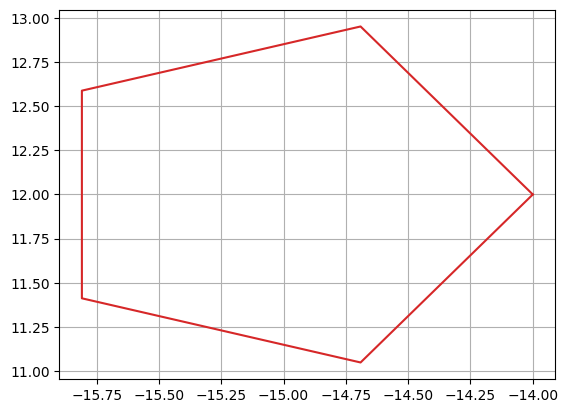

In [339]:
_ = Object2D(
    *[
        Point2D(x, y)
        for x, y in zip(object_points_x, object_points_y)
    ]
).plot()

In [321]:
from bbtoolkit.preprocessing.environment import EnvironmentBuilder


builder = EnvironmentBuilder(
    min(np.min(object_points_x), np.min(object_points_y)),
    max(np.max(object_points_x), np.max(object_points_y)),
    min(np.min(object_points_x), np.min(object_points_y)),
    max(np.max(object_points_x), np.max(object_points_y)),
    res=0.3
)

builder.add_object(*objects)

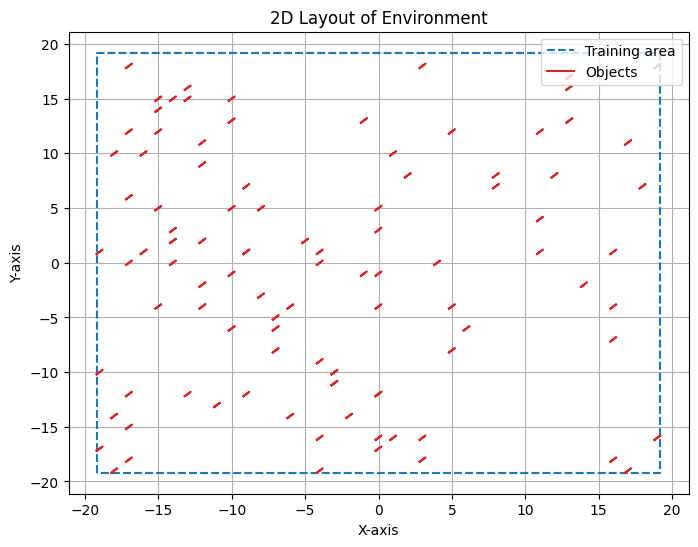

In [322]:
_ = builder.plot()

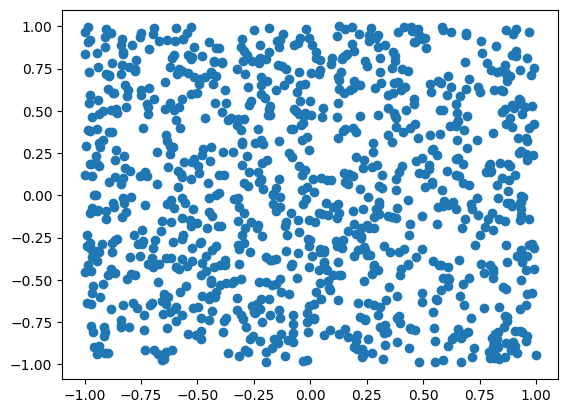

In [64]:
xy = 2*np.random.rand(1000, 2) - 1
x = xy[:, 0]
y = xy[:, 1]

plt.plot(x, y, 'o')

In [379]:
def make_fov_filter(x: np.ndarray, y: np.ndarray, angle1: float, angle2: float) -> tuple[np.ndarray, np.ndarray]:
    # Convert angles to range [-pi, pi]
    angle1 = (angle1 + np.pi) % (2 * np.pi) - np.pi
    angle2 = (angle2 + np.pi) % (2 * np.pi) - np.pi

    # Calculate the angles of the points
    angles = np.arctan2(y, x)

    # Check if angle1 is smaller than angle2
    if angle1 < angle2:
        mask = (angles >= angle1) & (angles <= angle2)
    else:
        # If angle1 is larger than angle2, the field of view wraps around the circle
        mask = (angles >= angle1) | (angles <= angle2)

    # Return only the points within the field of view
    return mask

In [78]:
def angle2fov(angle: float) -> tuple[float, float]:
    # Convert the angle to radians
    radian_angle = np.radians(angle)

    # Calculate the two values
    value1 = (np.pi - radian_angle) / 2
    value2 = (np.pi + radian_angle) / 2

    return value1, value2

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def plot_arrow(angle, x, y, ax=None, **kwargs):
    """
    Plot an arrow at a specified angle with given x and y coordinates.

    Parameters:
    - angle: Angle in radians (from 0 to 2*pi).
    - x: X-coordinate of the arrow.
    - y: Y-coordinate of the arrow.
    - ax: Optional axis for the plot. If not provided, a new plot is created.
    - **kwargs: Keyword arguments passed to the matplotlib.pyplot.arrow function.

    Returns:
    - fig: The figure on which the arrow is plotted.
    """
    # 0 ~ pi/2
    # pi/2 ~ 0
    # pi ~ 3*pi/2
    # 3*pi/2 ~ 2*pi
    angle = np.pi/2 - angle

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    kwargs.setdefault('head_width', 1)
    kwargs.setdefault('head_length', 1)
    kwargs.setdefault('fc', 'red')
    kwargs.setdefault('ec', 'red')

    # Calculate the arrow components
    arrow_length = 0.2
    dx = arrow_length * np.cos(angle)
    dy = arrow_length * np.sin(angle)

    # Plot the arrow
    ax.arrow(x, y, dx, dy, **kwargs)

    return fig



In [199]:
def filter_linear_segments_deprecated(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Filters out linear segments from a set of points.

    Args:
        x (np.ndarray): An array of x-coordinates.
        y (np.ndarray): An array of y-coordinates.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple of arrays of x- and y-coordinates of the filtered points.
    """
    points = np.column_stack((x, y))
    diffs = np.diff(points, axis=0)
    distances = np.linalg.norm(diffs, axis=1)
    indices = np.insert(np.where(~np.isclose(np.diff(distances), 0, 1e-7))[0] + 1, 0, 0)

    if indices[-1] != len(points) - 1:
        indices = np.append(indices, len(points) - 1)

    points = points[indices]
    return points[:, 0], points[:, 1]

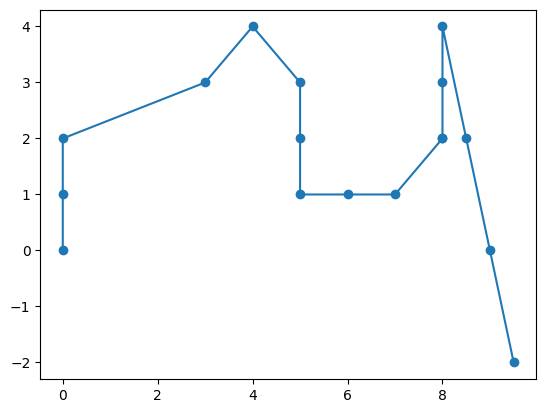

In [262]:
x = np.array([0, 0, 0, 3, 4, 5, 5, 5, 6, 7, 8, 8, 8, 8, 8.5, 9, 9.5])
y = np.array([0, 1, 2, 3, 4, 3, 2, 1, 1, 1, 2, 2, 3, 4, 2, 0, -2])
plt.plot(x, y, 'o-')

In [258]:
x.shape, mask.shape

((14,), (8,))

In [264]:
def filter_linear_segments(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Filters out linear segments from a set of points.

    Args:
        x (np.ndarray): An array of x-coordinates.
        y (np.ndarray): An array of y-coordinates.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple of arrays of x- and y-coordinates of the filtered points.
    """
    points = np.column_stack((x, y))
    diffs = np.diff(points, axis=0)
    mask = np.zeros_like(diffs, dtype=bool)
    mask[1:] = diffs[1:] == diffs[:-1]
    mask = np.append(np.logical_and(mask[:, 0], mask[:, 1]), False)
    x_filtered, y_filtered = x[~mask], y[~mask]

    return x_filtered, y_filtered

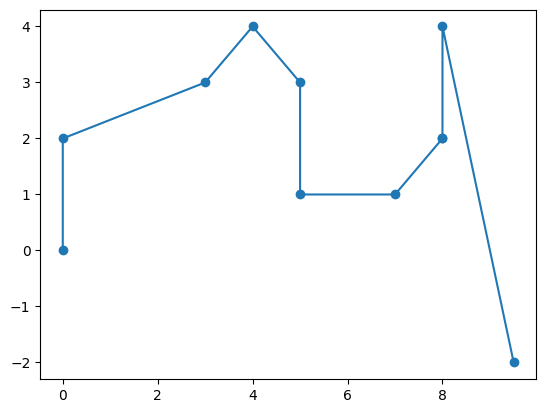

In [263]:

plt.plot(x_filtered, y_filtered, 'o-')

In [233]:
x, y = fov_x, fov_y
points = np.column_stack((x, y))
diffs = np.diff(points, axis=0)
distances = np.linalg.norm(diffs, axis=1)

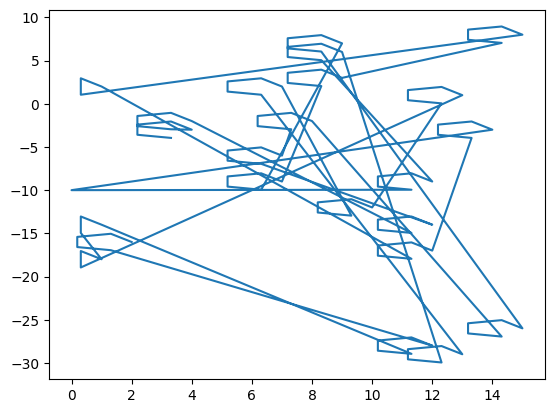

In [265]:
plt.plot(fov_x, fov_y)

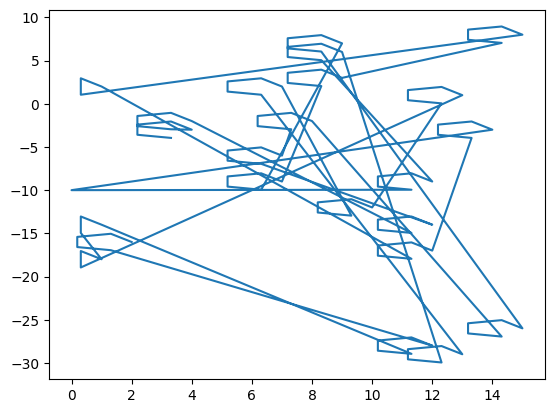

In [266]:
plt.plot(*filter_linear_segments(fov_x, fov_y))

### no object

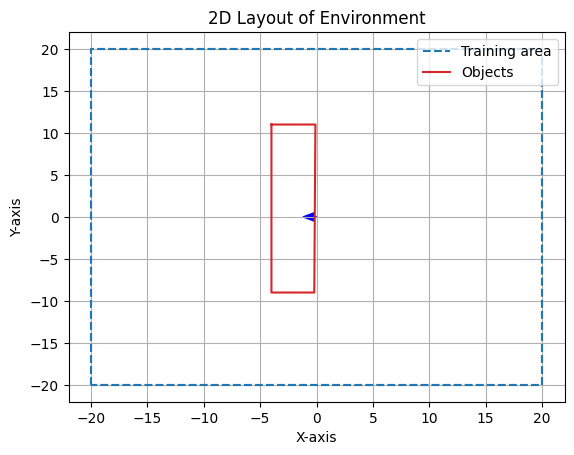

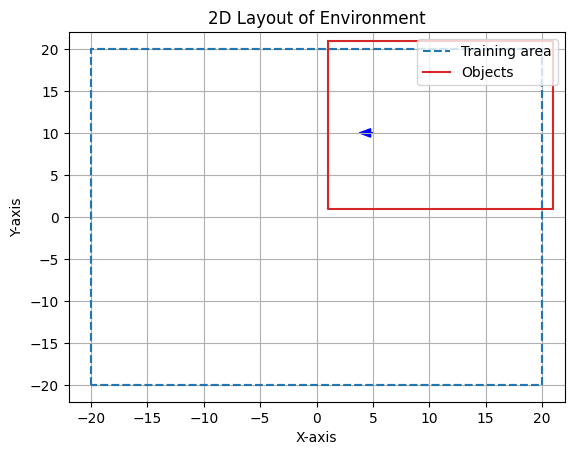

In [200]:
obj = False
res = 0.3
fov_angle = 180

agent_x = 5
agent_y = 10
# agent_x = 5
# agent_y = 15
# agent_hd = np.pi
agent_hd = 3*np.pi/2
# agent_hd = np.pi/2
# agent_hd = 0

geometry_ = geometry.copy()
# geometry_.boundary.coords.x = object_points_x.reshape(-1)
# geometry_.boundary.coords.y = object_points_y.reshape(-1)

training_space = geometry_.training_space.copy()
training_space.coords = Coordinates2D(x=np.array([agent_x]), y=np.array([agent_y]))

if obj:
    training_space.starting_points = np.ones_like(training_space.starting_points) * np.array([[agent_x, agent_y, 0]])

vp = process_visible_plane(
    geometry_.boundary,
    training_space
)
existing_points_indices = np.where(~np.isnan(vp.coords.x[0]))[0]
visible_boundary = Boundary(
    coords=Coordinates2D(
        x=vp.coords.x[0, existing_points_indices] - training_space.coords.x,
        y=vp.coords.y[0, existing_points_indices] - training_space.coords.y
    ),
    textures=vp.textures[0, existing_points_indices]
)

r = np.array([
    [np.cos(agent_hd), -np.sin(agent_hd)],
    [np.sin(agent_hd), np.cos(agent_hd)]
])

if obj:
    r = r.T

rotated_coords = r@np.stack([visible_boundary.coords.x, visible_boundary.coords.y])
visible_boundary_rotated = Boundary(
    coords=Coordinates2D(
        x=rotated_coords[0],
        y=rotated_coords[1]
    ),
    textures=visible_boundary.textures
)

# mask_180_deg = rotated_coords[1] > 0
# fov_x = visible_boundary.coords.x[mask_180_deg] # field of view
# fov_y = visible_boundary.coords.y[mask_180_deg]
mask = make_fov_filter(visible_boundary_rotated.coords.x, visible_boundary_rotated.coords.y, *angle2fov(fov_angle))
fov_x = visible_boundary.coords.x[mask] # field of view
fov_y = visible_boundary.coords.y[mask]


if fov_x.size != 0:
    diffvec = np.diff(np.stack([fov_x, fov_y]), axis=1)
    diffsum = np.abs(diffvec).sum(axis=0)

    ranges = find_index_ranges(diffsum, lambda x: np.round(x*10, 0) == int(training_space.resolution*10) - int(obj)) # wtf with this condition?!
    # ranges = find_index_ranges(diffsum, lambda x: np.round(x*10, 0) < int(training_space.resolution*10))
    ranges = [[start, min(stop + 1, len(diffsum) - 1)] for start, stop in ranges] # stop + 1 to include the point at the end of the range
    indices = [i for range_ in ranges for i in range_]
    fov_x_filtered, fov_y_filtered = filter_linear_segments(fov_x, fov_y)
    landmarks = np.stack([fov_x[indices], fov_y[indices]], 0)
    landmarks_rotated = r@landmarks
    egocue = np.reshape(landmarks_rotated, (4, -1), order='F').T
else:
    landmarks_rotated = np.array([])
    egocue = np.array([])

# egocue

visible_objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(fov_x, fov_y)
        ]
    )
]
builder = EnvironmentBuilder(
    -20, 20,
    res=0.3
)

builder.add_object(*visible_objects)

fig, ax = plt.subplots()
_ = builder.plot(ax = ax)
_ = plot_arrow(agent_hd, 0, 0, ax=ax, fc='blue', ec='blue')
###
visible_objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(visible_boundary.coords.x + training_space.coords.x, visible_boundary.coords.y + training_space.coords.y)
        ]
    )
]
builder = EnvironmentBuilder(
    -20, 20,
    res=0.3
)

builder.add_object(*visible_objects)
fig, ax = plt.subplots()
_ = builder.plot(ax = ax)
_ = plot_arrow(agent_hd, agent_x, agent_y, ax=ax, fc='blue', ec='blue')

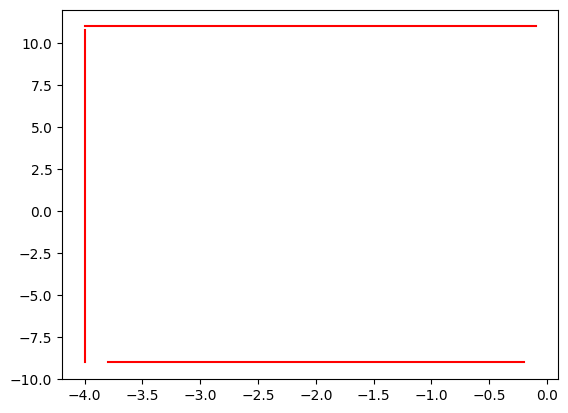

In [201]:
for cue in np.reshape(landmarks, (4, -1), order='F').T:
    xi, yi, xf, yf = cue
    plt.plot([xi, xf], [yi, yf], '-', color='r')

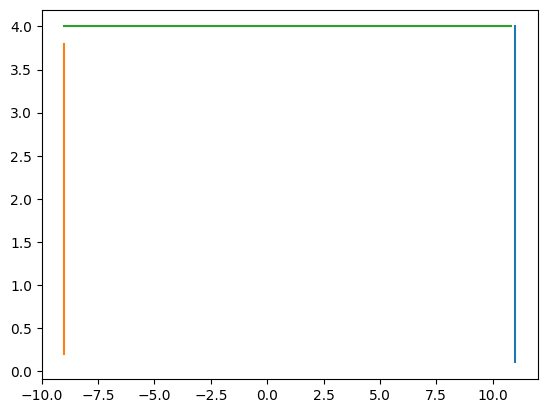

In [202]:
for cue in egocue:
    xi, yi, xf, yf = cue
    plt.plot([xi, xf], [yi, yf], '-')

In [ ]:
fov_y

array([11. , 11. , 11. , 11. , 11. , 11. , 11. , 11. , 11. , 11. , 11. ,
       11. , 11. , 11. , -9. , -9. , -9. , -9. , -9. , -9. , -9. , -9. ,
       -9. , -9. , -9. , -9. , -9. , -9. , -9. , -8.7, -8.4, -8.1, -7.8,
       -7.5, -7.2, -6.9, -6.6, -6.3, -6. , -5.7, -5.4, -5.1, -4.8, -4.5,
       -4.2, -3.9, -3.6, -3.3, -3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2,
       -0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,
        2.4,  2.7,  3. ,  3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,
        5.7,  6. ,  6.3,  6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,
        9. ,  9.3,  9.6,  9.9, 10.2, 10.5, 10.8, 11. ])

In [113]:
diffsum

array([ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3, 20.1,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.2,  0. ,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.2])

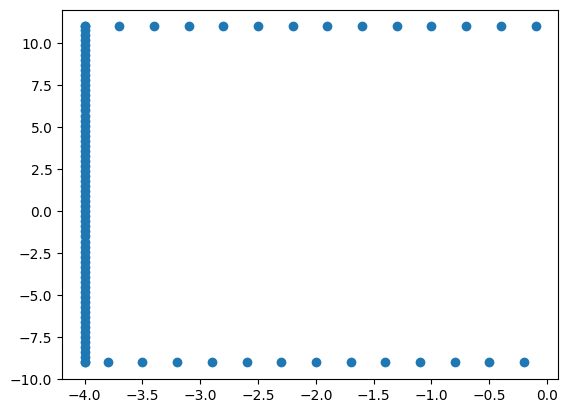

In [ ]:
plt.plot(fov_x, fov_y, 'o')

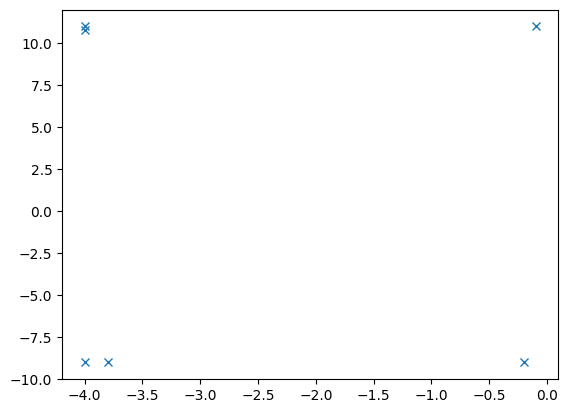

In [ ]:
plt.plot(landmarks[0], landmarks[1], 'x')

### object

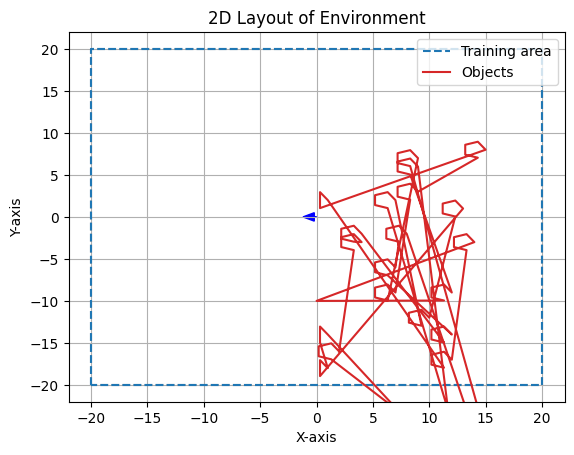

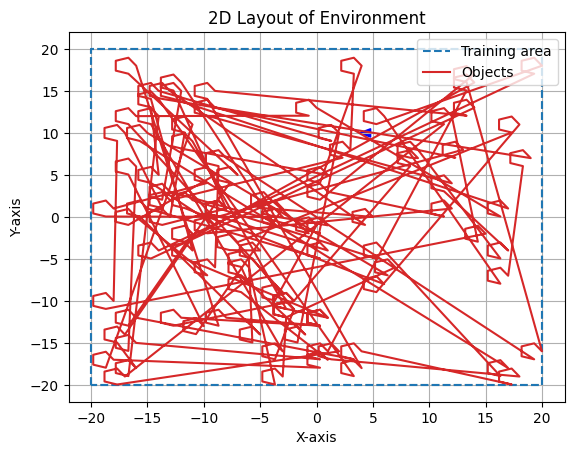

In [310]:
obj = True
res = 0.3
fov_angle = 180

agent_x = 5
agent_y = 10
# agent_x = 5
# agent_y = 15
# agent_hd = np.pi
agent_hd = 3*np.pi/2
# agent_hd = np.pi/2
# agent_hd = 0

geometry_ = geometry.copy()
geometry_.boundary.coords.x = object_points_x.reshape(-1)
geometry_.boundary.coords.y = object_points_y.reshape(-1)

training_space = geometry_.training_space.copy()
training_space.coords = Coordinates2D(x=np.array([agent_x]), y=np.array([agent_y]))

if obj:
    training_space.starting_points = np.ones_like(training_space.starting_points) * np.array([[agent_x, agent_y, 0]])

vp = process_visible_plane(
    geometry_.boundary,
    training_space
)
existing_points_indices = np.where(~np.isnan(vp.coords.x[0]))[0]
visible_boundary = Boundary(
    coords=Coordinates2D(
        x=vp.coords.x[0, existing_points_indices] - training_space.coords.x,
        y=vp.coords.y[0, existing_points_indices] - training_space.coords.y
    ),
    textures=vp.textures[0, existing_points_indices]
)

r = np.array([
    [np.cos(agent_hd), -np.sin(agent_hd)],
    [np.sin(agent_hd), np.cos(agent_hd)]
])

if obj:
    r = r.T

rotated_coords = r@np.stack([visible_boundary.coords.x, visible_boundary.coords.y])
visible_boundary_rotated = Boundary(
    coords=Coordinates2D(
        x=rotated_coords[0],
        y=rotated_coords[1]
    ),
    textures=visible_boundary.textures
)

# mask_180_deg = rotated_coords[1] > 0
# fov_x = visible_boundary.coords.x[mask_180_deg] # field of view
# fov_y = visible_boundary.coords.y[mask_180_deg]
mask = make_fov_filter(visible_boundary_rotated.coords.x, visible_boundary_rotated.coords.y, *angle2fov(fov_angle))
fov_x = visible_boundary.coords.x[mask] # field of view
fov_y = visible_boundary.coords.y[mask]


if fov_x.size != 0:
    # diffvec = np.diff(np.stack([fov_x, fov_y]), axis=1)
    # diffsum = np.abs(diffvec).sum(axis=0)

    # ranges = find_index_ranges(diffsum, lambda x: np.round(x*10, 0) == int(training_space.resolution*10) - int(obj)) # wtf with this condition?!
    # # ranges = find_index_ranges(diffsum, lambda x: np.round(x*10, 0) < int(training_space.resolution*10))
    # ranges = [[start, min(stop + 1, len(diffsum) - 1)] for start, stop in ranges] # stop + 1 to include the point at the end of the range
    # indices = [i for range_ in ranges for i in range_]
    fov_x_filtered, fov_y_filtered = filter_linear_segments(fov_x, fov_y)
    # landmarks = np.stack([fov_x[indices], fov_y[indices]], 0)
    landmarks = np.stack([fov_x_filtered, fov_y_filtered], 0)
    landmarks_rotated = r@landmarks
    egocue = np.reshape(landmarks_rotated, (4, -1), order='F').T
else:
    landmarks_rotated = np.array([])
    egocue = np.array([])

# egocue

visible_objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(fov_x, fov_y)
        ]
    )
]
builder = EnvironmentBuilder(
    -20, 20,
    res=0.3
)

builder.add_object(*visible_objects)

fig, ax = plt.subplots()
_ = builder.plot(ax = ax)
_ = plot_arrow(agent_hd, 0, 0, ax=ax, fc='blue', ec='blue')
###
visible_objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(visible_boundary.coords.x + training_space.coords.x, visible_boundary.coords.y + training_space.coords.y)
        ]
    )
]
builder = EnvironmentBuilder(
    -20, 20,
    res=0.3
)

builder.add_object(*visible_objects)
fig, ax = plt.subplots()
_ = builder.plot(ax = ax)
_ = plot_arrow(agent_hd, agent_x, agent_y, ax=ax, fc='blue', ec='blue')

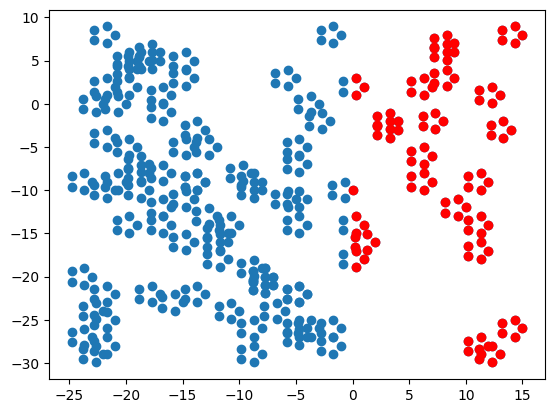

In [312]:
plt.plot(visible_boundary.coords.x, visible_boundary.coords.y, 'o')
plt.plot(fov_x, fov_y, 'or')

In [ ]:
def points2lines(points: np.ndarray) -> np.ndarray:
    # two closest points are a line
    # twline has two points - start and end

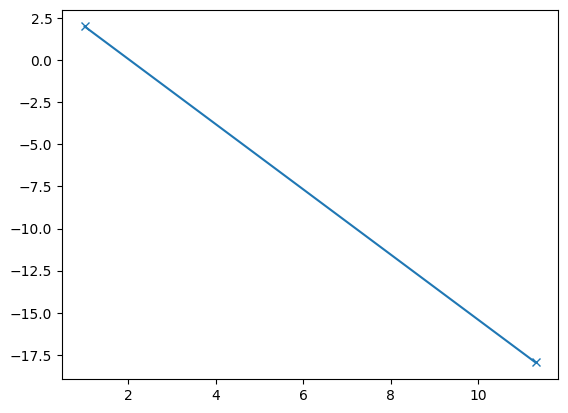

In [228]:
i = 26
plt.plot(fov_x_filtered[i:i+2], fov_y_filtered[i:i+2], 'x-')

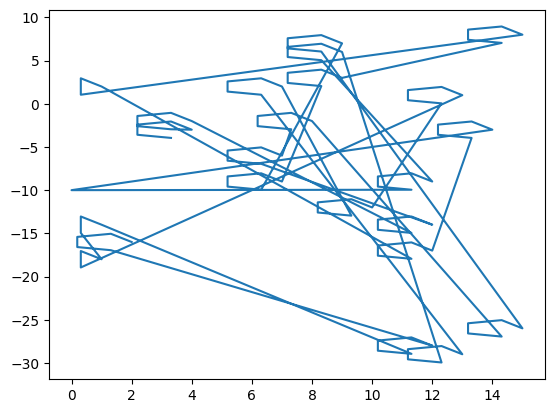

In [270]:
fov_x_filtered, fov_y_filtered = filter_linear_segments(fov_x, fov_y)

plt.plot(fov_x_filtered, fov_y_filtered, '-')

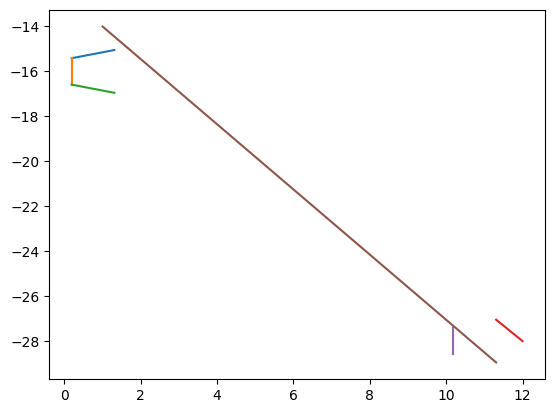

In [287]:
i = 5
plt.plot(fov_x_filtered[[1,2]], fov_y_filtered[[1,2]], '-')
plt.plot(fov_x_filtered[[2, 3]], fov_y_filtered[[2, 3]], '-')
plt.plot(fov_x_filtered[[3, 4]], fov_y_filtered[[3, 4]], '-')
plt.plot(fov_x_filtered[[5, 6]], fov_y_filtered[[5, 6]], '-')
plt.plot(fov_x_filtered[[7, 8]], fov_y_filtered[[7, 8]], '-')
plt.plot(fov_x_filtered[[9, 10]], fov_y_filtered[[9, 10]], '-')

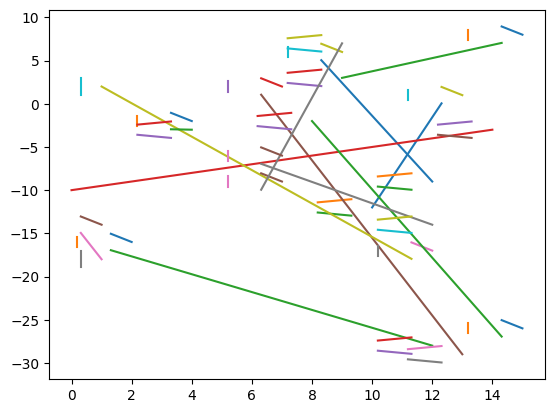

In [269]:
for cue in np.reshape(landmarks, (4, -1), order='F').T:
    xi, yi, xf, yf = cue
    plt.plot([xi, xf], [yi, yf], '-', )

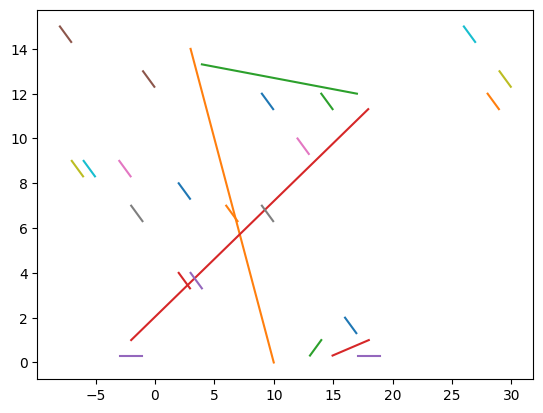

In [220]:
for cue in egocue:
    xi, yi, xf, yf = cue
    plt.plot([xi, xf], [yi, yf], '-')

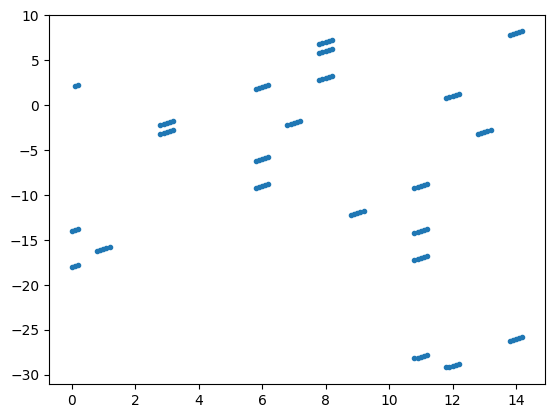

In [121]:
plt.plot(fov_x, fov_y, '.')

In [ ]:
diffsum

array([ 0.2,  0.2,  0.2,  0.2,  2.8,  0.2,  0.2,  0.2,  0.2, 11. ,  0.2,
        0.2,  0.2,  0.2, 20.2,  0.2,  0.2,  0.2,  0.2, 32. ,  0.2,  0.2,
        0.2,  0.2,  5.8,  0.2,  0.2,  0.2,  0.2, 24. ,  0.2,  0.2, 21. ,
        0.2,  0.2,  0.2,  0.2, 23.2,  0.2,  0.2,  0.2,  0.2, 37.8,  0.2,
        0.2,  0.2,  0.2, 26.2,  0.2,  0.2,  0.2,  0.2, 13.8,  0.2,  0.2,
        0.2,  0.2, 16. ,  0.2,  0.2,  0.2,  0.2, 10.8,  0.2,  0.2,  0.2,
        0.2, 11.2,  0.2,  0.2,  0.2,  0.2, 16. ,  0.2,  0.2,  0.2,  0.2,
        4.8,  0.2,  0.2,  0.2,  0.2, 23.8,  0.2,  0.2,  0.2,  0.2, 20. ,
        0.2, 23. ,  0.2,  0.2,  0.2,  0.2, 15.8,  0.2,  0.2,  0.2,  0.2,
       27.2,  0.2,  0.2,  0.2,  0.2, 23.8,  0.2,  0.2,  0.2,  0.2,  5.8,
        0.2,  0.2,  0.2,  0.2,  6.2,  0.2,  0.2,  0.2,  0.2,  6. ,  0.2,
        0.2,  0.2,  0.2,  7.2,  0.2,  0.2,  0.2,  0.2, 16. ,  0.2,  0.2,
        0.2,  0.2, 17.8,  0.2,  0.2,  0.2,  0.2, 26. ,  0.2,  0.2, 21. ,
        0.2,  0.2,  0.2,  0.2, 16.8,  0.2,  0.2,  0

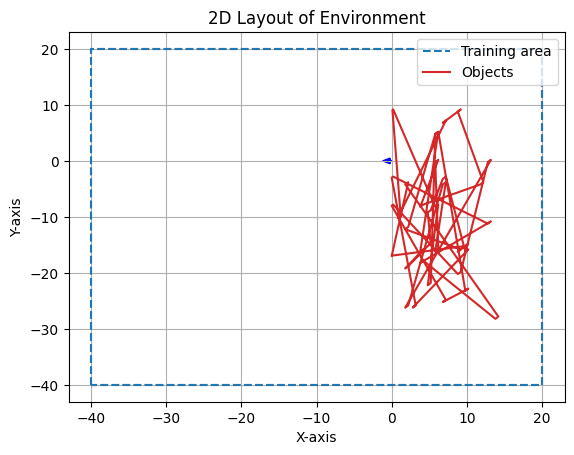

In [ ]:
visible_objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(landmarks[0], landmarks[1])
        ]
    )
]
builder = EnvironmentBuilder(
    -40, 20,
    res=0.3
)

builder.add_object(*visible_objects)
fig, ax = plt.subplots()
_ = builder.plot(ax = ax)
_ = plot_arrow(agent_hd, 0, 0, ax=ax, fc='blue', ec='blue')

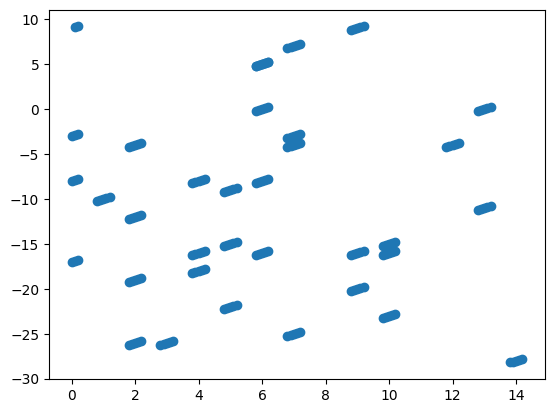

In [ ]:
plt.plot(fov_x, fov_y, 'o')

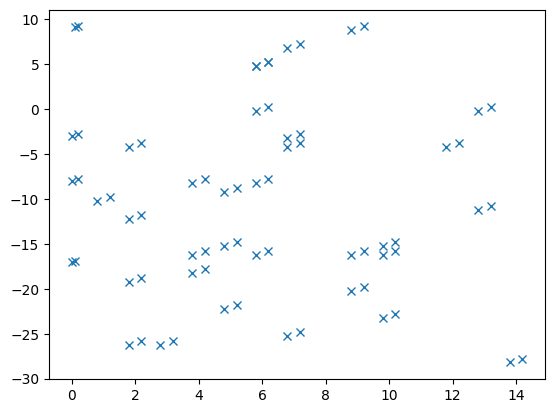

In [ ]:
plt.plot(landmarks[0], landmarks[1], 'x')

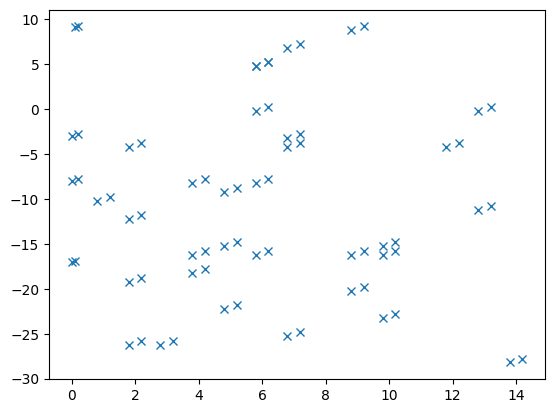

In [ ]:
plt.plot(landmarks[0], landmarks[1], 'x')

### object new

In [293]:
geometry_.training_space.coords.y.max()

21.9

In [314]:
np.arange(0, 1.3, .3)

array([0. , 0.3, 0.6, 0.9, 1.2])

In [295]:
def create_pentagrams(centers, r=1):
    n_points = centers.shape[1]
    x_coords = np.zeros((n_points, 5))
    y_coords = np.zeros((n_points, 5))

    for i in range(n_points):
        for j in range(5):
            angle = 2 * np.pi * j / 5
            x_coords[i, j] = centers[0, i] + r * np.cos(angle)
            y_coords[i, j] = centers[1, i] + r * np.sin(angle)

    return x_coords, y_coords

object_points_x, object_points_y = create_pentagrams(object_coords.T, 1)

In [294]:
geometry.params.__dict__.keys()

dict_keys(['max_xy', 'min_xy', 'min_train', 'max_train', 'max_n_obj_points', 'n_objects', 'n_polygons', 'n_textures', 'n_vertices', 'objects'])

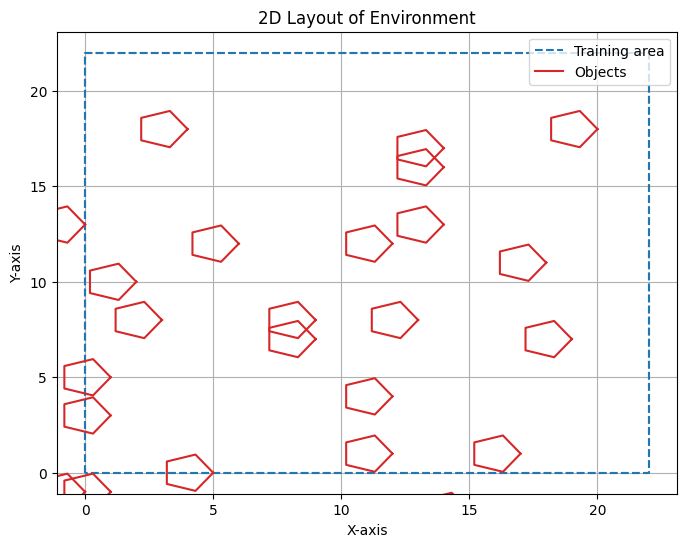

In [296]:
geometry_ = geometry.copy()

builder = EnvironmentBuilder(
    geometry.params.min_xy,
    geometry.params.max_xy,
    (geometry.params.min_train.x, geometry.params.min_train.y),
    (geometry.params.max_train.x, geometry.params.max_train.y),
    res=geometry.training_space.resolution
)

objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(object_points_x[i], object_points_y[i])
        ]
    )
    for i in range(n_objects)
]

builder.add_object(*objects)

_ = builder.plot()

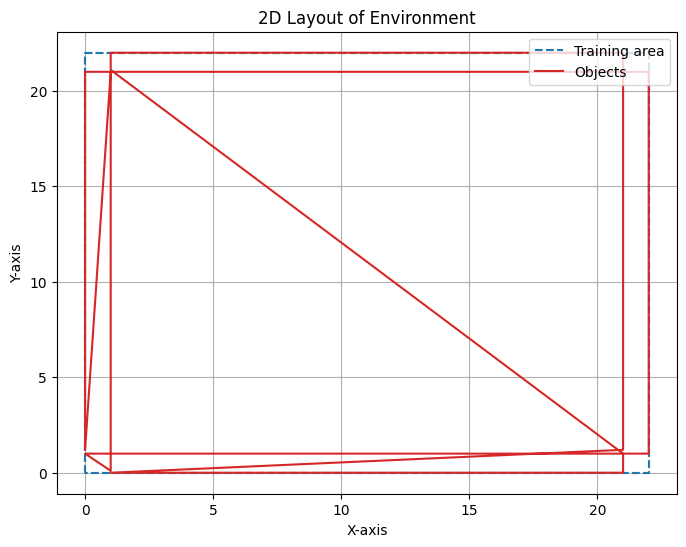

In [309]:
geometry_ = geometry.copy()

builder = EnvironmentBuilder(
    geometry.params.min_xy,
    geometry.params.max_xy,
    (geometry.params.min_train.x, geometry.params.min_train.y),
    (geometry.params.max_train.x, geometry.params.max_train.y),
    res=geometry.training_space.resolution
)

objects = [
    Object2D(
        *[
            Point2D(x, y)
            for x, y in zip(geometry_.boundary.coords.x, geometry_.boundary.coords.y)
        ]
    )
]

builder.add_object(*objects)

_ = builder.plot()

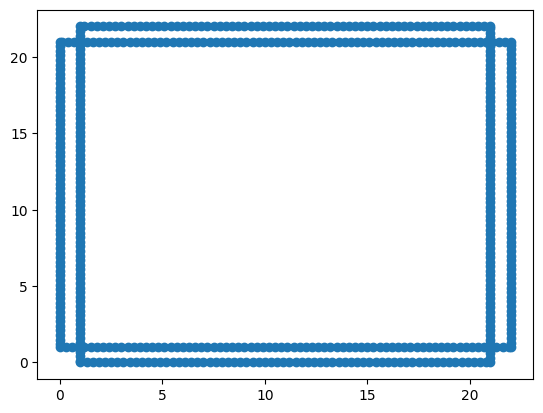

In [308]:
plt.scatter(
    geometry_.boundary.coords.x,
    geometry_.boundary.coords.y,
)

### geometry check

In [ ]:
landmarks.shape, fov_x.shape, fov_y.shape

((2, 70), (166,), (166,))

In [ ]:
agent_x, agent_y, agent_hd

(5, 10, 3.141592653589793)

In [ ]:
agent_x, agent_y, agent_hd

(5, 10, 3.141592653589793)

In [ ]:
# geometry = Geometry.load('../data/envs/squared_room.pkl')
geometry = Geometry.load('../data/envs/preplay_env_closed.pkl')

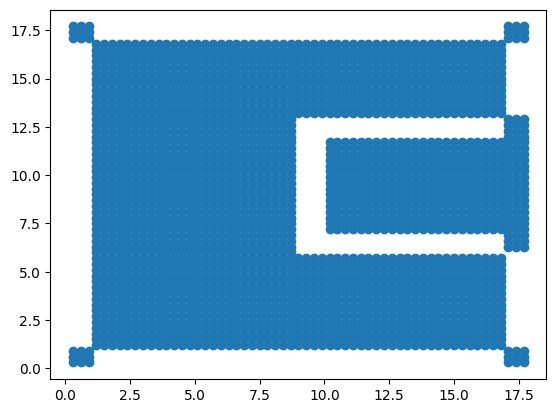

In [ ]:
plt.scatter(
    geometry.training_space.coords.x,
    geometry.training_space.coords.y
)

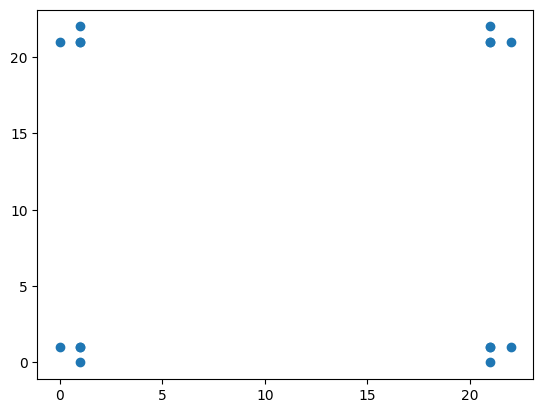

In [ ]:
plt.scatter(
    geometry.training_space.starting_points[:, :-1][:, 0],
    geometry.training_space.starting_points[:, :-1][:, 1]
)

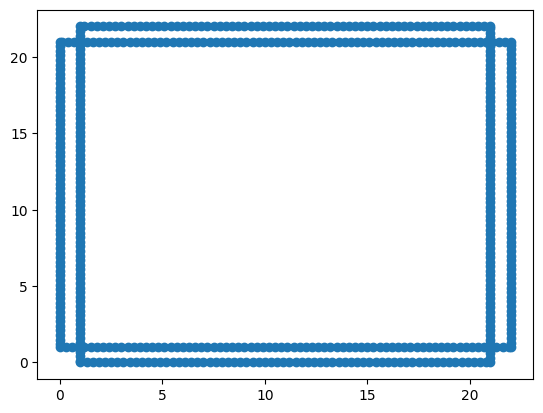

In [ ]:
plt.scatter(
    geometry.boundary.coords.x,
    geometry.boundary.coords.y,
)